# Projet de Matching CV vs Offres d'emploi

Ce notebook présente l'analyse de similarité entre une base de données de CVs et une base d'offres d'emploi.

## Workflow
1. **Anonymisation**
1. **Extraction** : Lecture des PDF (structure complexe pour les CV, simple pour les offres).
2. **Nettoyage** : Unification du texte, suppression des accents et caractères spéciaux.
3. **Vectorisation** : Utilisation de modèles de langage (SentenceTransformer, Universal Sentence Encoder), appariement CV-Offre à la main.
4. **Comparaison** : Calcul de la distance cosinus selon deux approches (Texte complet vs Découpage par sections).

Anonymisation 

Pour les tests effectués jusqu'ici, l'anonymisation a été effectuée manuellement en retirant l'encart du profil su rle pdf. 
Pour la suite, il faudrait faire une pseudonimisation afin que chaque CV ait un identifiant et que l'on puisse contacter la personne qui a matché avec l'offre. 

In [14]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
import pdfplumber
import tensorflow as tf
import tensorflow_hub as hub
from pathlib import Path
from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# --- CONFIGURATION DES CHEMINS ---
BASE_DIR = Path.cwd() 
CV_DIR = BASE_DIR / "data" / "cv"
OFFRES_DIR = BASE_DIR / "data" / "offre"

# Vérification rapide
if not CV_DIR.exists():
    print(f" Attention : Le dossier {CV_DIR} n'existe pas.")
else:
    print(f"Dossier CV détecté : {len(list(CV_DIR.glob('*.pdf')))} fichiers trouvés.")

Dossier CV détecté : 17 fichiers trouvés.


Fonctions de nettoyage des pdf 

In [ ]:
def clean_text(txt):
    if not isinstance(txt, str): return ""
    replacements = {"*": "", "’": "'", "‘": "'", "\t": " ", "\n": " ", "\r": ""}
    for old, new in replacements.items():
        txt = txt.replace(old, new)
    txt = unidecode.unidecode(txt)
    txt = " ".join(txt.split()) 
    return txt.strip()

def segmenter_texte_par_mots_cles(texte): #Divise le texte en sections (Expérience, Formation, Compétences)
    sections = {"Experience": [], "Formation": [], "Competences": [], "Autre": []}
    keywords = {
        "Experience": ["experience", "expériences", "parcours", "postes", "emploi", "professionnel"],
        "Formation": ["formation", "education", "diplomes", "études", "cursus"],
        "Competences": ["competences", "hard skills", "outils", "langues", "logiciels", "atouts"]
    }
    current_section = "Autre"
    
    for ligne in texte.split('.'): 
        ligne_clean = ligne.strip()
        if not ligne_clean: continue
        
        if len(ligne_clean) < 50: 
            for section, triggers in keywords.items():
                if any(trigger in ligne_clean.lower() for trigger in triggers):
                    current_section = section
                    break
        sections[current_section].append(ligne_clean)
        
    return {k: " ".join(v) for k, v in sections.items()}

def extraire_cv_complexe(pdf_path): #Extraction structurée (Gauche/Droite) 
    contenu_final = {"Experience": [], "Formation": [], "Competences": [], "Autre": []}
    
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                width = page.width
                height = page.height
                
                # DÉCOUPAGE COLONNES 
                try:
                    # On définit les zones théoriques
                    bbox_gauche = (0, 0, width * 0.30, height)
                    bbox_droite = (width * 0.30, 0, width, height)
                    
                    # On coupe, Si les marges sont bizarres, ça va sauter au 'except'
                    zone_gauche = page.crop(bbox_gauche, relative=False, strict=True)
                    zone_droite = page.crop(bbox_droite, relative=False, strict=True)
                    
                    txt_gauche = zone_gauche.extract_text() or ""
                    txt_droite = zone_droite.extract_text() or ""
                    
                    # Segmentation si le découpage a marché
                    seg_gauche = segmenter_texte_par_mots_cles(txt_gauche)
                    seg_droite = segmenter_texte_par_mots_cles(txt_droite)
                    
                    for key in contenu_final.keys():
                        contenu_final[key].append(seg_gauche[key])
                        contenu_final[key].append(seg_droite[key])

                # EXTRACTION SIMPLE # Si le découpage échoue (erreur de bounding box), on lit tout d'un bloc
                except ValueError:
                    full_text = page.extract_text() or ""
                    seg_simple = segmenter_texte_par_mots_cles(full_text)
                    for key in contenu_final.keys():
                        contenu_final[key].append(seg_simple[key])
                    
        return {k: clean_text(" ".join(v)) for k, v in contenu_final.items()}

    except Exception as e:
        print(f" Erreur critique sur {pdf_path.name}: {e}")
        return None

def extraire_texte_simple(pdf_path): #Extraction standard pour les offres
    try:
        reader = PdfReader(pdf_path)
        text = [page.extract_text() for page in reader.pages if page.extract_text()]
        return clean_text(" ".join(text))
    except Exception as e:
        print(f" Erreur Offre {pdf_path.name}: {e}")
        return ""

In [20]:
# Listes pour stocker les données
cv_data = []      # Dictionnaires avec les 3 sections
cv_full_text = [] # Texte complet
cv_names = []

offre_full_text = []
offre_names = []

# Chargement des CV
for f in sorted(list(CV_DIR.glob("*.pdf"))):
    data = extraire_cv_complexe(f)
    if data:
        cv_data.append(data)
        full = f"{data['Experience']} {data['Formation']} {data['Competences']} {data['Autre']}"
        cv_full_text.append(full)
        cv_names.append(f.name)
        print(f"  -> {f.name} OK")

# Chargement des Offres
for f in sorted(list(OFFRES_DIR.glob("*.pdf"))):
    txt = extraire_texte_simple(f)
    if txt:
        offre_full_text.append(txt)
        offre_names.append(f.name)
        print(f"  -> {f.name} OK")

  -> CV-barman.pdf OK
  -> CV-boucher.pdf OK
  -> CV-patissier.pdf OK
  -> CV-vendeur.pdf OK
  -> CVchimiste.pdf OK
  -> CVnassima.pdf OK
  ⚠️ Marges complexes sur Cvcamille.pdf, passage en lecture simple...
  -> Cvcamille.pdf OK
  -> Cvcommerce non ano.pdf OK
  -> Cvcommerce.pdf OK
  -> Cvcommunication non ano.pdf OK
  -> Cvcommunication.pdf OK
  ⚠️ Marges complexes sur Cvsixtine.pdf, passage en lecture simple...
  ⚠️ Marges complexes sur Cvsixtine.pdf, passage en lecture simple...
  -> Cvsixtine.pdf OK
  -> Cvvalentine.pdf OK
  -> cvchef.pdf OK
  -> designer stylist.pdf OK
  -> directeur financier.pdf OK
  -> sales & trading intern.pdf OK
  -> Offre-barman.pdf OK
  -> Offrebucheron.pdf OK
  -> Offrecomptable.pdf OK
  -> Offregardien.pdf OK
  -> Offremodel.pdf OK
  -> Offretest.pdf OK
  -> ambulancier.pdf OK
  -> animateur 2D_3D.pdf OK
  -> offre-aide soignant.pdf OK
  -> offre-boucher.pdf OK
  -> offre-chorégraphe.pdf OK
  -> offre-kiné.pdf OK
  -> offre-patissier.pdf OK
  -> offre

Vectorisation 

In [7]:
# Chargement modele SentenceTransformer
model_st = SentenceTransformer('all-mpnet-base-v2')

In [9]:
#Chargement de Universal Sentence Encoder (USE)
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

In [17]:
# TEXTE COMPLET (1 BLOC) 
# Sentence Transformer
cv_vec_st = model_st.encode(cv_full_text)
of_vec_st = model_st.encode(offre_full_text)
dist_1bloc_st = 1 - cosine_similarity(cv_vec_st, of_vec_st)

# USE
cv_vec_use = model_use(cv_full_text).numpy()
of_vec_use = model_use(offre_full_text).numpy()
dist_1bloc_use = 1 - cosine_similarity(cv_vec_use, of_vec_use)

# STRUCTURE (3 BLOCS) 
# On vectorise séparément Expérience, Compétences, Formation
comp_st = model_st.encode([d['Competences'] for d in cv_data])
exp_st = model_st.encode([d['Experience'] for d in cv_data])
form_st = model_st.encode([d['Formation'] for d in cv_data])

comp_use = model_use([d['Competences'] for d in cv_data]).numpy()
exp_use = model_use([d['Experience'] for d in cv_data]).numpy()
form_use = model_use([d['Formation'] for d in cv_data]).numpy()

def calc_dist_3blocs(v_comp, v_exp, v_form, v_offre):
    d_comp = 1 - cosine_similarity(v_comp, v_offre)
    d_exp = 1 - cosine_similarity(v_exp, v_offre)
    d_form = 1 - cosine_similarity(v_form, v_offre)
    return d_comp + d_exp + d_form

dist_3blocs_st = calc_dist_3blocs(comp_st, exp_st, form_st, of_vec_st)
dist_3blocs_use = calc_dist_3blocs(comp_use, exp_use, form_use, of_vec_use)

Visualisation 

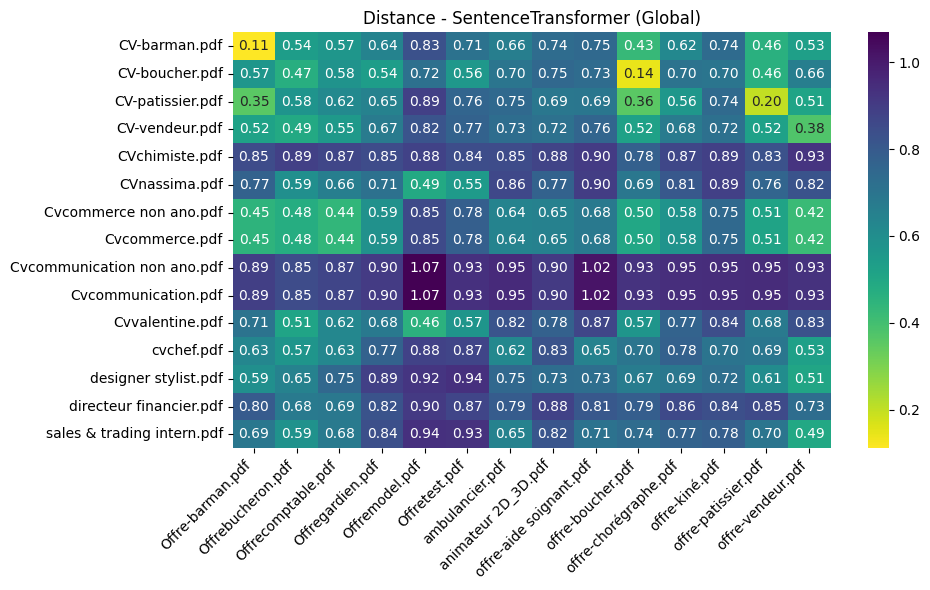

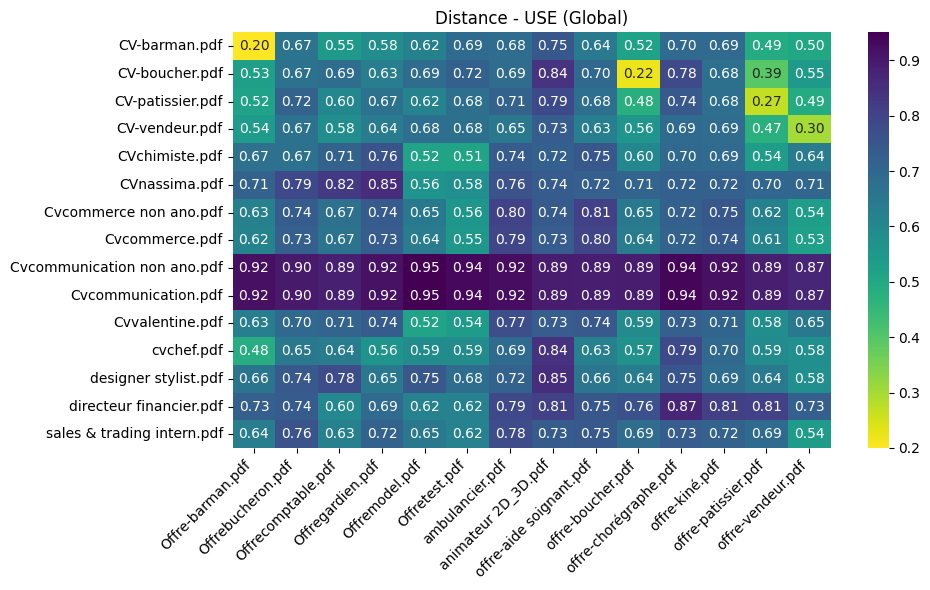

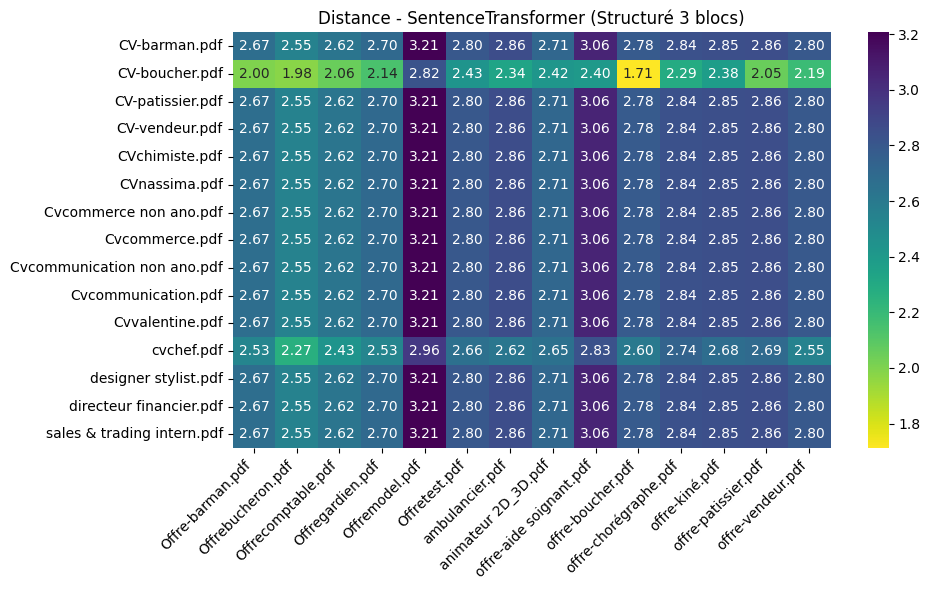

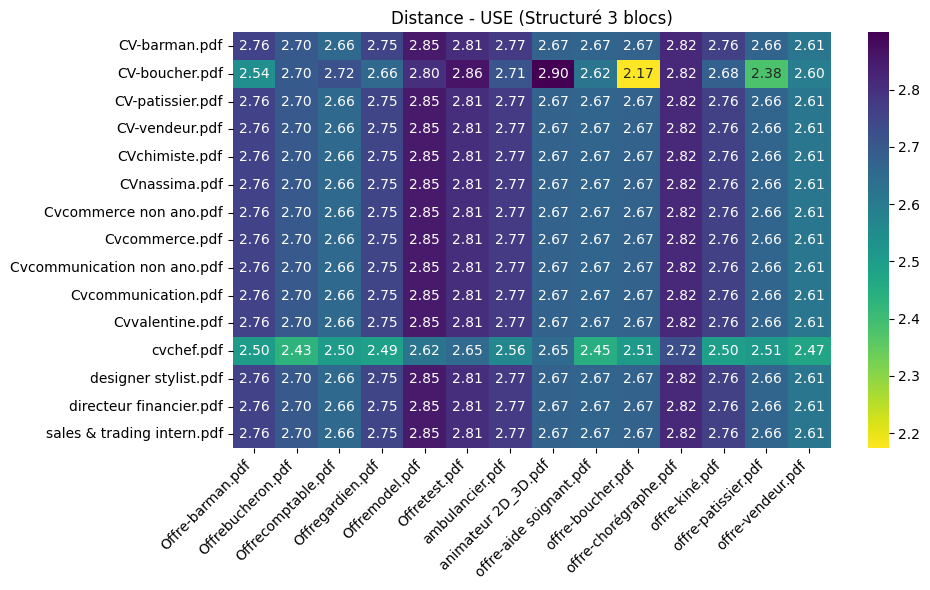

In [18]:
def plot_heatmap(data, title):
    plt.figure(figsize=(10, 6))
    # cmap="viridis_r" -> Plus c'est foncé, plus la distance est FAIBLE (donc meilleur match)
    sns.heatmap(
        data,
        annot=True,
        fmt=".2f",
        cmap="viridis_r", 
        xticklabels=offre_names,
        yticklabels=cv_names
    )
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Affichage des 4 matrices
plot_heatmap(dist_1bloc_st, "Distance - SentenceTransformer (Global)")
plot_heatmap(dist_1bloc_use, "Distance - USE (Global)")
plot_heatmap(dist_3blocs_st, "Distance - SentenceTransformer (Structuré 3 blocs)")
plot_heatmap(dist_3blocs_use, "Distance - USE (Structuré 3 blocs)")